# The Fate of Online Retail Post-pandemic
---
### An analysis of the effect of the COVID-19 interruption on the online retail rates in the UK

Exploratory Data Analysis to determine the optimal model parameters is first conducted. Online retail rate data is decomposed using STL (Seasonal and Trend Decomposition using LOESS) as well as analysed for non-stationariness, autocorrelation and partial autocorrelation. The results are used to fit a SARIMA (Seasonal AutoRegressive Integrated Moving Average) counterfactual model without the effect of the COVID-19 pandemic. The SARIMA counterfactual model will then be compared to historical data as well as evaluated for its accuracy.

*All graphs used in the poster have the poster aesthetics, all graphs not used have default parameters.*

### Table of Contents
* [1. Installing Libraries](#1_Installing_Libraries)
* [2. Importing Data and Data Preparation](#2_Importing_Data_and_Data_Preparation)
* [3. Plotting Original Time-Series](#3_Plotting_Original_Time-Series)
* [4. Seasonality: Fourier Transform and STL Decomposition](#4_Seasonality:_Fourier_Transform_and_STL_Decomposition)
* [5. Integrated: Dickey-Fuller Test and Differencing](#5_Integrated:_Dickey-Fuller_Test_and_Differencing)
* [6. AutoRegressive/Moving_Average: ACF and PACF](#6_AutoRegressive/Moving_Average:_ACF_and_PACF)
* [7. Forecasting](#7_Forecasting)
* [8. Model Evaluation](#8_Model_Evaluation)

---

# 1_Installing_Libraries

In [1]:
pip install -r requirements.txt

Note: you may need to restart the kernel to use updated packages.


In [226]:
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
from scipy import stats
import scipy.stats as sp
import warnings
import itertools
import statsmodels.api as sm
import pmdarima as pm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX

# 2_Importing_Data_and_Data_Preparation

In [211]:
# Importing original dataset
original_df = pd.read_csv("data/raw_data.csv")

# Importing processed dataframes split into pre-pandemic, training, and testing data, as well as pandemic data
train_df = pd.read_csv("data/train_processed.csv")
test_df = pd.read_csv("data/test_processed.csv")
pandemic_df = pd.read_csv("data/pandemic_processed.csv")

In [252]:
# Renaming variables in original dataset
original_df["Time"] = original_df["Year"]
original_df["Online Retail Rate"] = original_df["Percentage"]

In [66]:
# Converting processed data into time series data
ts_train = train_df[['Time','Online Retail Rate']]
ts_train = ts_train.set_index('Time')
ts_test = train_df[['Time','Online Retail Rate']]
ts_test = ts_test.set_index('Time')
ts_pandemic = train_df[['Time','Online Retail Rate']]
ts_pandemic = ts_pandemic.set_index('Time')

# 3_Plotting_Original_Time-Series

In [171]:
# Setting color scheme for all graphs
BACKGROUND_COLOR = '#323941'
FONT_COLOR = 'white'
SPINE_COLOR = '#41b0b9'

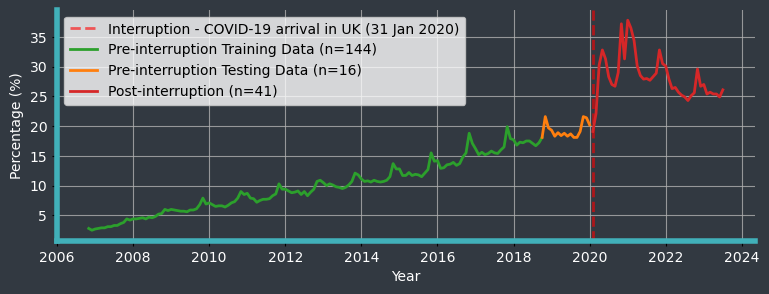

In [172]:
# Creating a line chart between Time and Online Retail Rate from the original full dataset
plt.figure(figsize=(9,3),facecolor=BACKGROUND_COLOR)
plt.axes(facecolor=BACKGROUND_COLOR)

# Plotting lines
plt.axvline(2020.083333, color='red', alpha=0.6, linewidth=2, linestyle='--', label="Interruption - COVID-19 arrival in UK (31 Jan 2020)")
plt.plot(original_df["Time"][:144], original_df["Online Retail Rate"][:144], color='C2', linewidth=2, label="Pre-interruption Training Data (n=144)")
plt.plot(original_df["Time"][143:159], original_df["Online Retail Rate"][143:159], color="C1", linewidth=2, label="Pre-interruption Testing Data (n=16)")
plt.plot(original_df["Time"][159:], original_df["Online Retail Rate"][159:], color="C3", linewidth=2, label = "Post-interruption (n=41)")

# Aesthetics
plt.grid(alpha=0.8)
plt.xticks([2006,2008,2010,2012,2014,2016,2018,2020,2022,2024], color=FONT_COLOR)
plt.yticks(color=FONT_COLOR)
plt.xlabel("Year", color=FONT_COLOR)
plt.ylabel("Percentage (%)", color=FONT_COLOR)
plt.legend(facecolor=FONT_COLOR)
ax = plt.gca()
ax.spines['bottom'].set_color(SPINE_COLOR)
ax.spines['left'].set_color(SPINE_COLOR)
ax.spines['top'].set_color('none')
ax.spines['right'].set_color('none')
ax.spines['bottom'].set_linewidth(4)
ax.spines['left'].set_linewidth(4)
plt.show()

# 4_Seasonality:_Fourier_Transform_and_STL_Decomposition

C:\Users\William Chang\AppData\Local\Temp\ipykernel_6856\4120645518.py:4: RuntimeWarning: divide by zero encountered in divide
  periods = 1/frequencies


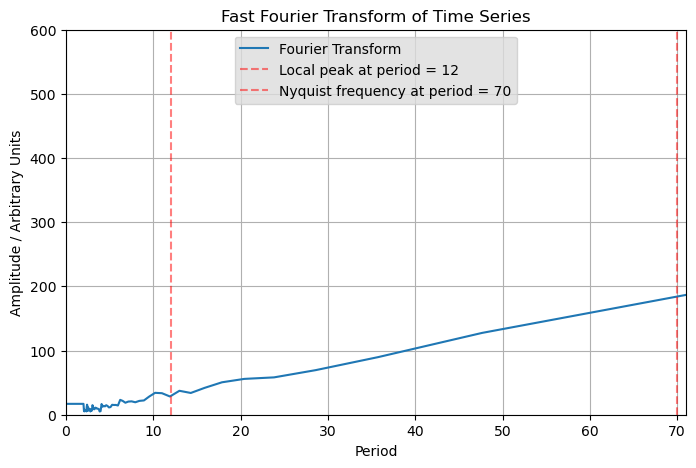

In [109]:
# Computing the Fourier Transform
fast_fourier_transform = np.fft.fft(train_df["Online Retail Rate"])
frequencies = np.fft.fftfreq(len(train_df["Online Retail Rate"]), d=1)  # Compute frequencies
periods = 1/frequencies
    
# Plotting the Fourier Transform
plt.figure(figsize=(8, 5))
plt.plot(periods, np.abs(fast_fourier_transform), label = "Fourier Transform")
plt.title('Fast Fourier Transform of Time Series')
plt.xlabel('Period')
plt.ylabel('Amplitude / Arbitrary Units')
plt.axvline(12,color='red',linestyle='--',alpha=0.5,label='Local peak at period = 12')
plt.grid(True)
plt.xlim(0,71)
plt.ylim(0,600)
plt.axvline(70,color='red',linestyle='--',alpha=0.5,label='Nyquist frequency at period = 70')
plt.legend(facecolor='gainsboro')
plt.show()

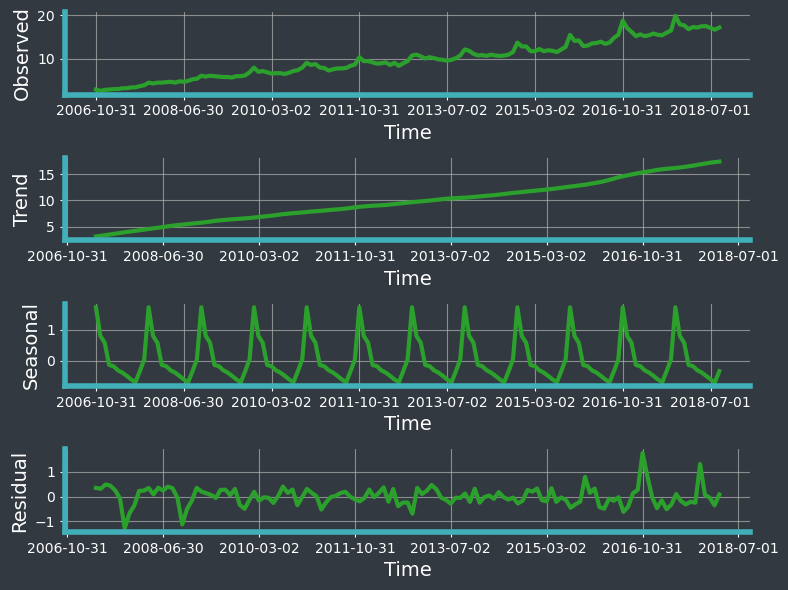

In [135]:
# Perform Seasonal Trend Decomposition using LOESS (STL) 
decomposition = seasonal_decompose(ts_train, model='additive', period=12)

# Create a custom-sized figure for the decomposition plot
fig, axes = plt.subplots(4, 1, figsize=(8, 6), facecolor=BACKGROUND_COLOR)  # 4 subplots for observed, trend, seasonal, and residual
fig.subplots_adjust(hspace=0.5) 

# Set spine color and thickness for bottom and left spines, disabling top and right spines, setting axes color, ticks and x-axis label
for ax in axes:
    ax.spines['bottom'].set_color(SPINE_COLOR)
    ax.spines['bottom'].set_linewidth(4)
    ax.spines['left'].set_color(SPINE_COLOR)
    ax.spines['left'].set_linewidth(4)
    ax.spines['right'].set_color('none') 
    ax.spines['top'].set_color('none')   
    ax.set_facecolor(BACKGROUND_COLOR)  
    ax.set_xlabel("Year", fontsize=14, color=FONT_COLOR)
    ax.tick_params(axis='x', which='both', colors=FONT_COLOR)
    ax.tick_params(axis='y', colors=FONT_COLOR)

# Plot the decomposition components with adjusted line color and linewidth
decomposition.observed.plot(ax=axes[0], legend=False, color='C2', linewidth=3)
axes[0].set_ylabel('Observed', fontsize=14, color='white')
axes[0].grid(True, alpha=0.7)  

decomposition.seasonal.plot(ax=axes[2], legend=False, color='C2', linewidth=3)
axes[2].set_ylabel('Seasonal', fontsize=14, color='white')
axes[2].grid(True, alpha=0.7) 

decomposition.trend.plot(ax=axes[1], legend=False, color='C2', linewidth=3)
axes[1].set_ylabel('Trend', fontsize=14, color='white')
axes[1].grid(True, alpha=0.7)  

decomposition.resid.plot(ax=axes[3], legend=False, color='C2', linewidth=3)
axes[3].set_ylabel('Residual', fontsize=14, color='white')
axes[3].grid(True, alpha=0.7) 

plt.tight_layout()
plt.show()


A period of 12 is observed as a seasonal component of the time series data. Additionally there appears to be a linear increasing trend observed after STL decomposition, violating the non-stationary assumption. This leads us to conduct a Dickey-Fuller test and difference the data

# 5_Integrated:_Dickey-Fuller_Test_and_Differencing

In [155]:
# Defining the Dickey-fuller test

def dickey_fuller_test(time_series):
    dickey_fuller_result = adfuller(time_series, autolag='AIC')
    dickey_fuller_output = pd.Series(dickey_fuller_result[0:4], index=["Test Statistic", "p-value", "Lags Used", "No. of Observations Used"])
    for key, value in dickey_fuller_result[4].items():
        dickey_fuller_output[f"Critical Value ({key})"] = value
    
    print(f"Results of Dickey-Fuller Test:\n{dickey_fuller_output}")

In [164]:
# Dickey-fuller test on original training data
dickey_fuller_test(ts_train)

Results of Dickey-Fuller Test:
Test Statistic                1.048993
p-value                       0.994757
Lags Used                    14.000000
No. of Observations Used    128.000000
Critical Value (1%)          -3.482501
Critical Value (5%)          -2.884398
Critical Value (10%)         -2.578960
dtype: float64


In [165]:
# Dickey-fuller test after first order differencing

# First-order differencing
ts_train_adjusted = train_df["Online Retail Rate"] - train_df["Online Retail Rate"].shift(1)
ts_train_adjusted = ts_train_adjusted.dropna()

# Dickey-fuller test
dickey_fuller_test(ts_train_adjusted)

Results of Dickey-Fuller Test:
Test Statistic               -3.202372
p-value                       0.019848
Lags Used                    14.000000
No. of Observations Used    127.000000
Critical Value (1%)          -3.482920
Critical Value (5%)          -2.884580
Critical Value (10%)         -2.579058
dtype: float64


In [166]:
# Dickey-fuller test after first order differencing and seasonal differencing

# Seasonal differencing
ts_train_seasonally_adjusted = ts_train_adjusted - ts_train_adjusted.shift(12)
ts_train_seasonally_adjusted = ts_train_seasonally_adjusted.dropna()

# Dickey-fuller test
dickey_fuller_test(ts_train_seasonally_adjusted)

Results of Dickey-Fuller Test:
Test Statistic             -7.342207e+00
p-value                     1.057956e-10
Lags Used                   3.000000e+00
No. of Observations Used    1.260000e+02
Critical Value (1%)        -3.483346e+00
Critical Value (5%)        -2.884766e+00
Critical Value (10%)       -2.579156e+00
dtype: float64


From the Dickey-Fuller tests, a non-significant p-value can be obtained after first order differencing in the non-seasonal component and differencing in the seasonal component

# 6_AutoRegressive/Moving_Average:_ACF_and_PACF

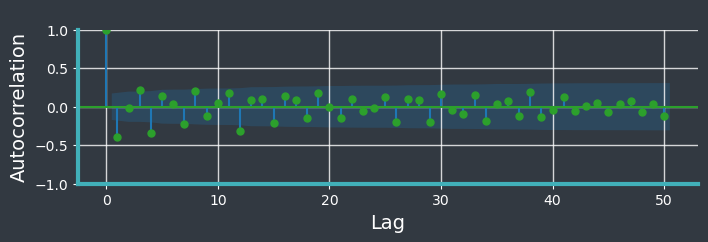

In [176]:
# Create a figure and axis for the ACF plot
fig_acf, ax_acf = plt.subplots(figsize=(8, 2), facecolor=BACKGROUND_COLOR)
plot_acf(ts_train_seasonally_adjusted, lags=50, ax=ax_acf, alpha=0.05, color='C2')

# Adjusting aesthetics
ax_acf.set_xlabel("Lag", fontsize=14, color=FONT_COLOR)
ax_acf.set_ylabel("Autocorrelation", fontsize=14, color=FONT_COLOR)
ax_acf.set_title(" ")  # Disable title
ax_acf.tick_params(axis='both', colors=FONT_COLOR)  
ax_acf.set_facecolor(BACKGROUND_COLOR)
ax_acf.grid(True, alpha=0.8, linewidth=1, color='white')  

# Adjust bottom and left spines color and thickness
ax_acf.spines['bottom'].set_color(SPINE_COLOR)
ax_acf.spines['bottom'].set_linewidth(3)
ax_acf.spines['left'].set_color(SPINE_COLOR)
ax_acf.spines['left'].set_linewidth(3)
ax_acf.spines['right'].set_color('none') 
ax_acf.spines['top'].set_color('none')

plt.show()

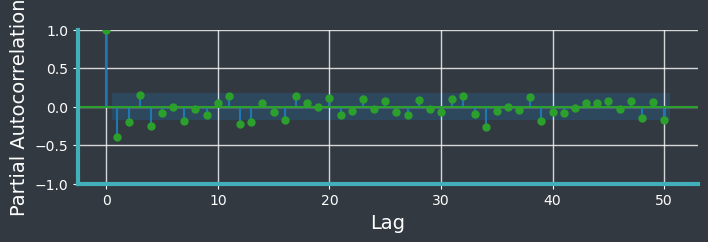

In [342]:
# Create a figure and axis for the PACF plot
fig_pacf, ax_pacf = plt.subplots(figsize=(8, 2), facecolor=BACKGROUND_COLOR)
plot_pacf(ts_train_seasonally_adjusted, lags=50, ax=ax_pacf, alpha=0.05, color='C2')

# Adjusting aesthetics
ax_pacf.set_xlabel("Lag", fontsize=14, color=FONT_COLOR)
ax_pacf.set_ylabel("Partial Autocorrelation", fontsize=14, color=FONT_COLOR)
ax_pacf.set_title(" ")  # Disable title
ax_pacf.tick_params(axis='both', colors=FONT_COLOR)  
ax_pacf.set_facecolor(BACKGROUND_COLOR)
ax_pacf.grid(True, alpha=0.8, linewidth=1, color='white')  

# Adjust bottom and left spines color and thickness
ax_pacf.spines['bottom'].set_color(SPINE_COLOR)
ax_pacf.spines['bottom'].set_linewidth(3)
ax_pacf.spines['left'].set_color(SPINE_COLOR)
ax_pacf.spines['left'].set_linewidth(3)
ax_pacf.spines['right'].set_color('none') 
ax_pacf.spines['top'].set_color('none')

plt.show()

The AutoRegressive (AR) and Moving Average (MA) components rely on autocorrelation (the correlation between a value and it’s past values) in the data points and residuals respectively. 

**Autocorrelation Plot:** Suggests how many terms is needed for the MA (q, Q) component in order to account for the autocorrelation in the model, it shows a significant autocorrelation at lag 1, 4 and 12. 

**Partial Autocorrelation Plot:** Suggests how many terms is needed for the AR (p, P) component, shows a significant autocorrelation at lag 1,2 and 4, and an exponential decay at 12, 24, 36.

**Optimal combination of orders:** Possible values for AR orders is (p = 1,2,4, P = 1), and for MA orders (q = 1,4, Q = 0).

# 7_Forecasting

In [184]:
# Defining the model parameters
p = 2
d = 1
q = 1
P = 1
D = 1
Q = 0
period = 12

# Create a SARIMA model with the chosen order and seasonal order
model = SARIMAX(ts_train, order=(p, d, q), seasonal_order=(P, D, Q, period)).fit()

# Print the summary of the model
print(model.summary())

C:\Users\William Chang\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\William Chang\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                                      SARIMAX Results                                      
Dep. Variable:                  Online Retail Rate   No. Observations:                  143
Model:             SARIMAX(2, 1, 1)x(1, 1, [], 12)   Log Likelihood                 -45.406
Date:                             Fri, 26 Jan 2024   AIC                            100.812
Time:                                     13:25:18   BIC                            115.149
Sample:                                          0   HQIC                           106.637
                                             - 143                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.0003      0.241     -4.148      0.000      -1.473      -0.528
ar.L2         -0.3931      

In [187]:
# Forecasting future values
STEPS = 58
forecast = model.get_forecast(steps=STEPS)

# Plot the forecasted values along with confidence intervals
forecast_confidence_intervals = forecast.conf_int(alpha=0.05)

C:\Users\William Chang\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


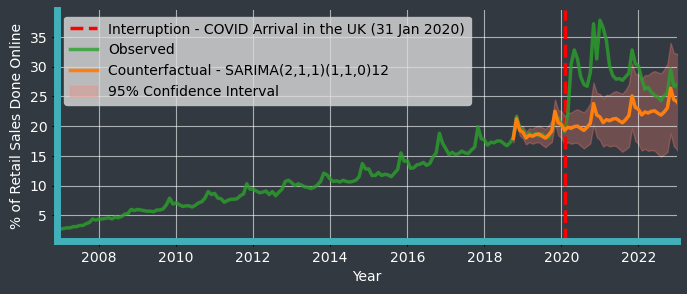

In [191]:
# Plotting a graph of original time series and the counterfactual model

# Creating a figure and axis
plt.figure(figsize=(8,3),facecolor=BACKGROUND_COLOR)
plt.axes(facecolor=BACKGROUND_COLOR)

# Plotting lines
plt.axvline(2020.0833, label="Interruption - COVID Arrival in the UK (31 Jan 2020)", color = 'red', alpha = 1, linestyle = '--', linewidth=2.5)
plt.plot(original_df["Time"][:159], original_df["Online Retail Rate"][:159], color='C2', alpha=0.8, linewidth=2.5, label='Observed')
plt.plot(original_df["Time"][159:185], original_df["Online Retail Rate"][159:185],color='C2', alpha=0.8, linewidth=2.5)
plt.plot(original_df["Time"][184:], original_df["Online Retail Rate"][184:], color='C2', alpha=0.8, linewidth=2.5)
plt.plot(original_df["Time"][143:202], forecast.predicted_mean, color='C1', linewidth=2.5, label='Counterfactual - SARIMA(2,1,1)(1,1,0)12')

# Plotting confidence interval
plt.fill_between(original_df["Time"][143:202], forecast_confidence_intervals.iloc[0:, 0], forecast_confidence_intervals.iloc[0:, 1], color='salmon', label='95% Confidence Interval', alpha=0.3)

# Plot Aesthetics
plt.xticks(range(2006,2026,2), color=FONT_COLOR)
plt.yticks(color=FONT_COLOR)
plt.xlabel('Year',color='white')
plt.ylabel('% of Retail Sales Done Online',color='white')
plt.xlim(2006.91,2023)
plt.grid(alpha=0.6, color='white')
plt.legend(loc='upper left', facecolor='gainsboro')

# Changing spine aesthetics
ax = plt.gca()
ax.spines['bottom'].set_color(SPINE_COLOR)
ax.spines['bottom'].set_linewidth(5)
ax.spines['left'].set_color(SPINE_COLOR)
ax.spines['left'].set_linewidth(5)
ax.spines['right'].set_color('none') 
ax.spines['top'].set_color('none')   

plt.show()


From the Counterfactual SARIMA Model, the following can be observed:
1. The spikes and seasonality observed in the observed data is not necessarily a result of the covid-pandemic but just natural fluctuations due to holiday seasons etc. This is inferred as the observed time-series is within the confidence interval of the counterfactual model.
2. As of 2023 July, observed data is slightly higher than counterfactual by about 2.6%, however, the difference had stopped being statistically significant since January 2022.

# 8_Model_Evaluation

In [225]:
# Obtaining residuals
forecasted_test_values = forecast.predicted_mean[:16]
actual_test_values = test_df["Online Retail Rate"]
test_residuals = np.array(forecasted_test_values) - np.array(actual_test_values)

# Calculating MSE and MAPE
mse = (test_residuals ** 2).mean()
mape = ((np.abs(test_residuals)) / actual_test_values).mean() * 100

# Printing results
print(f'The Mean Squared Error is {round(mse, 3)}')
print(f'The Root Mean Squared Error is {round(np.sqrt(mse), 3)}')
print(f'The MAPE is {round(mape,3)}')

The Mean Squared Error is 0.173
The Root Mean Squared Error is 0.416
The MAPE is 1.744


In [228]:
# Obtaining residuals for training data
residuals = model.resid
residuals = residuals[1:]

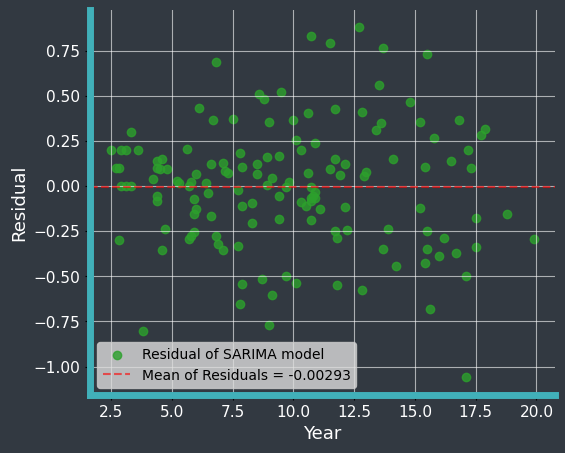

In [253]:
# Residual plot

# Plotting and changing aesthetics
plt.figure(figsize=(6, 5), facecolor=BACKGROUND_COLOR) 
plt.axes(facecolor=BACKGROUND_COLOR)
plt.scatter(original_df["Online Retail Rate"][:len(residuals)], residuals, alpha=0.8, label="Residual of SARIMA model", color='C2')
plt.axhline(np.mean(residuals), alpha=0.6, color='red', linestyle='--', label=f'Mean of Residuals = {round(np.mean(residuals), 5)}')
plt.legend(facecolor='gainsboro')
plt.grid(color='white', alpha=0.6)
plt.xlabel("Year", color=FONT_COLOR, fontsize=13)
plt.ylabel("Residual", color=FONT_COLOR, fontsize=13)
plt.xticks(color=FONT_COLOR, fontsize=11) 
plt.yticks(color=FONT_COLOR, fontsize=11) 

# Changing spine aesthetics
ax = plt.gca()
ax.spines['bottom'].set_color(SPINE_COLOR)
ax.spines['bottom'].set_linewidth(5)
ax.spines['left'].set_color(SPINE_COLOR)
ax.spines['left'].set_linewidth(5)
ax.spines['right'].set_color("none")
ax.spines['top'].set_color("none")

plt.show()


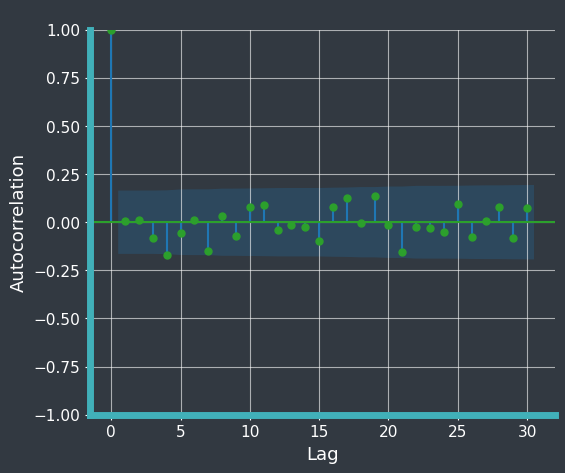

In [246]:
# Autocorrelation plot of the residuals

# Creating a figure and axis
fig, ax = plt.subplots(figsize=(6, 5), facecolor=BACKGROUND_COLOR)  
ax.set_facecolor(BACKGROUND_COLOR) 

# Plotting and changing aesthetics
plot_acf(residuals, lags=30, ax=ax, color='C2')
ax.set_title(" ")
ax.set_xlabel("Lag", color=FONT_COLOR, fontsize=13)
ax.set_ylabel("Autocorrelation", color=FONT_COLOR, fontsize=13)
ax.tick_params(axis='both', colors=FONT_COLOR, labelsize=11)  
ax.grid(color='white', alpha=0.6)

# Changing spine aesthetics
ax.spines['bottom'].set_color(SPINE_COLOR)
ax.spines['bottom'].set_linewidth(5)
ax.spines['left'].set_color(SPINE_COLOR)
ax.spines['left'].set_linewidth(5)
ax.spines['right'].set_color("none")
ax.spines['top'].set_color("none")

plt.show()

In [265]:
# Calculating theoretical quantiles
residuals_sorted = np.sort(residuals)
residual_length = len(residuals)
sample_quantiles = residuals / np.std(np.array(original_df["Online Retail Rate"][:len(residuals)]) + residuals)

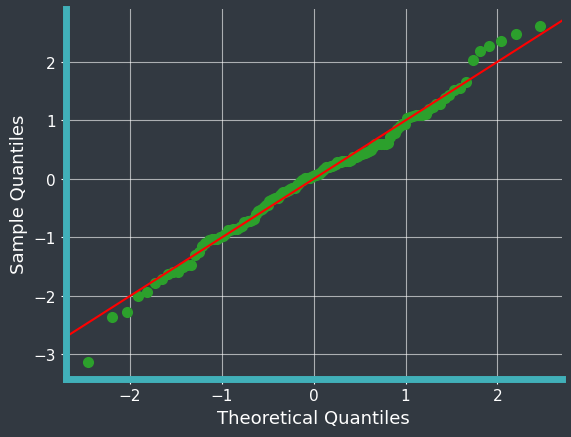

In [339]:
# Plotting QQ plot of residuals

# Plotting QQ plot
qq_plot = sm.qqplot(residuals, line='45', fit=True, markeredgecolor='#2ca02c', markerfacecolor='#2ca02c', markersize=7)


# Changing figure and axis
fig = plt.gcf()
ax = plt.gca()
fig.set_facecolor(BACKGROUND_COLOR)
ax.set_facecolor(BACKGROUND_COLOR)

# Changing aesthetics
plt.xlim(-2.7, 2.7) 
ax.set_xlabel("Theoretical Quantiles", color=FONT_COLOR, fontsize=13)
ax.set_ylabel("Sample Quantiles", color=FONT_COLOR, fontsize=13)
ax.tick_params(axis='both', colors=FONT_COLOR, labelsize=11)  
ax.yaxis.label.set_color(FONT_COLOR)
ax.grid(color='white', alpha=0.6)

# Changing spine aesthetics
ax.spines['bottom'].set_color(SPINE_COLOR)
ax.spines['bottom'].set_linewidth(5)
ax.spines['left'].set_color(SPINE_COLOR)
ax.spines['left'].set_linewidth(5)
ax.spines['right'].set_color("none")
ax.spines['top'].set_color("none")

plt.show()

Counterfactual Model Evaluation:

1. Mean of residuals close to 0
(Mean = -0.00293) (5dp)
2. Constant variance shown in
residual plot
2. No Autocorrelation in
residuals indicating all relevant
information was used in model
3. Normality of residuals shown by
sample quantiles following identity
line in Quantile-Quantile Plot